In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

In [ ]:
!pip install transformers pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 130.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 40.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take 

In [ ]:
import spacy
import requests
import string
from gensim.models import TfidfModel
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

In [ ]:
def get_wikipedia_content(title, lang="en"):
    # Base URL per l'API di Wikipedia
    base_url = f"https://{lang}.wikipedia.org/w/api.php"

    # Parametri per la richiesta API
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,  # Ottieni il testo senza marcature HTML
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Estrai il contenuto dalla risposta
    pages = data["query"]["pages"]
    for page_id, page_data in pages.items():
        return page_data['extract']

    return None

title = "Italy"
content = get_wikipedia_content(title)
print(content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Italy (Italian: Italia [iˈtaːlja] ), officially the Italian Republic or the Republic of Italy, is a country in Southern and Western Europe. Located in the middle of the Mediterranean Sea, it consists of a peninsula delimited by the Alps and surrounded by several islands.
Italy shares land borders with France, Switzerland, Austria, Slovenia and the enclaved microstates of Vatican City and San Marino. It has a territorial exclave in Switzerland (Campione) and an archipelago in the African Plate (Pelagie Islands). Italy covers an area of 301,340 km2 (116,350 sq mi), with a population of about 60 million; it is the tenth-largest country by land area in the European continent and the third-most populous member state of the European Union. Its capital and largest city is Rome.
The Italian peninsula was historically the native place of numerous ancient peoples and destination of a myriad of different peoples and cultures who immigrated throughout history. The ancient Roman state arose in Lati

In [ ]:
# 1. Initialization: download necessary resources and load models
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# For NER, we'll use spacy. Ensure you've downloaded the English model 'en_core_web_sm'
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # 2. Lowercasing
    text = text.lower()

    # 3. Tokenize sentences and words
    sentences = sent_tokenize(text)
    tokens = [word_tokenize(sentence) for sentence in sentences]

    # 4. Remove stop words and punctuations
    tokens = [[word for word in sentence if word not in stop_words and word not in string.punctuation]
              for sentence in tokens]

    return tokens

def create_bag_of_words(tokens):
    # 5. Create a Bag of Words using Gensim
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]
    return dictionary, corpus

def compute_tfidf(corpus):
    # 6. Compute TF-IDF
    tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

def top_n_words_from_tfidf(corpus_tfidf, dictionary, n=10):
    # Flatten the corpus_tfidf and sort by the tf-idf value
    sorted_tfidf = sorted([(dictionary[id], value) for doc in corpus_tfidf for id, value in doc],
                          key=lambda x: x[1], reverse=True)

    # Pick top n words
    top_words = [word for word, value in sorted_tfidf[:n]]
    return top_words

def perform_ner(text):
    # 7. Named Entity Recognition (NER)
    doc = nlp(text)
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]
    return named_entities

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Example usage:
tokens = preprocess_text(content)
dictionary, corpus = create_bag_of_words(tokens)
corpus_tfidf = compute_tfidf(corpus)
entities = perform_ner(content)
top_words = top_n_words_from_tfidf(corpus_tfidf, dictionary, 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#print("Tokens:", tokens)
#print("Bag of Words:", corpus)
#print("Named Entities:", entities)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Assuming 'tokens' is the list of tokenized documents, as defined in the previous code.
# tokens = preprocess_text(your_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

# Train the LDA model
num_topics = 1  # You can adjust this based on your needs
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def extract_topic_from_text(text, num_topics=5, topn=3):
    tokens = preprocess_text(text)

    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(t) for t in tokens]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Get the dominant topic for the given text
    dominant_topic = sorted(lda_model[corpus[0]], key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]

    # Get top `topn` words from this topic
    topic_words = lda_model.show_topic(topic_id, topn=topn)
    dominant_words = [word for word, _ in topic_words]

    # Return the most dominant word or phrase
    return ' '.join(dominant_words)

# Example usage:
topic = extract_topic_from_text(content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['factbook',
 'navy',
 '==',
 'sport',
 'species',
 'gardens',
 'composers',
 'festivities',
 'agency',
 'britannica']

In [ ]:
topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'italian italy world'

In [ ]:
nltk.download('vader_lexicon')

def analyze_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)

    return sentiment_scores

# Example usage:
text = content

sentiment = analyze_sentiment_vader(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
score = sentiment['neg'] * (-1) + sentiment['neu'] * 0 + sentiment['pos'] * 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.04

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


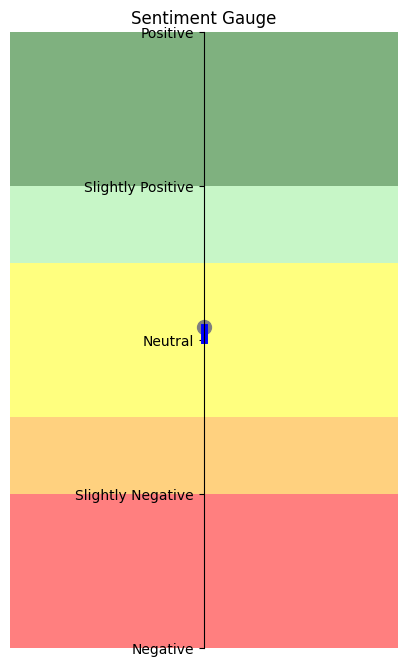

In [ ]:
def plot_sentiment(sentiment_value):
    # Create a vertical sentiment gauge
    fig, ax = plt.subplots(figsize=(5, 8))

    # Set the axis limits and labels
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1, 1)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([])
    ax.set_yticklabels(["Negative", "Slightly Negative", "Neutral", "Slightly Positive", "Positive"])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position('center')

    # Plot the sentiment value
    ax.plot([0, 0], [0, sentiment_value], color="blue", lw=5, label="Sentiment")
    ax.scatter([0], [sentiment_value], color="blue", s=100)

    # Highlight the neutral area
    ax.axhspan(-1, -0.5, facecolor='red', alpha=0.5)
    ax.axhspan(-0.5, -0.25, facecolor='orange', alpha=0.5)
    ax.axhspan(-0.25, 0, facecolor='yellow', alpha=0.5)
    ax.axhspan(0, 0.25, facecolor='yellow', alpha=0.5)
    ax.axhspan(0.25, 0.5, facecolor='lightgreen', alpha=0.5)
    ax.axhspan(0.5, 1, facecolor='darkgreen', alpha=0.5)

    # Title
    ax.set_title("Sentiment Gauge")

    plt.show()

# Plot the sentiment
plot_sentiment(score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
